In [1]:
# for figure 3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import lasso_path, enet_path
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

import nbimporter
from helpers import expr_data
from helpers import scale_data
from helpers import similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(53711)
random.seed(53711)

#### Load all data

In [4]:
data = expr_data.ExprData()
data.load_pickle()
# data = data.remove_by_wlname(['ycsb', 'xml'])
data = data.fix_tpch()
# data = data.sample_data()

#### Split by SKU

In [5]:
data_by_sku = data.split_by_sku()

In [6]:
def sparse_argsort(arr):
    indices = np.nonzero(arr)[0]
    return indices[np.argsort(arr[indices])]

In [7]:
print(list(enumerate(data_by_sku['cpu2'].wl_names)))

[(0, 'tpcc'), (1, 'tpcc'), (2, 'tpcc'), (3, 'tpcc'), (4, 'tpcc'), (5, 'tpcc'), (6, 'tpcc'), (7, 'tpcc'), (8, 'tpcc'), (9, 'tpch'), (10, 'tpch'), (11, 'tpch'), (12, 'tpch'), (13, 'tpch'), (14, 'tpch'), (15, 'tpch'), (16, 'tpch'), (17, 'tpch'), (18, 'twitter'), (19, 'twitter'), (20, 'twitter'), (21, 'twitter'), (22, 'twitter'), (23, 'twitter'), (24, 'twitter'), (25, 'twitter'), (26, 'twitter'), (27, 'ycsb'), (28, 'ycsb'), (29, 'ycsb'), (30, 'ycsb'), (31, 'ycsb'), (32, 'ycsb'), (33, 'ycsb'), (34, 'ycsb'), (35, 'ycsb')]


cpu_num=cpu16
cpu_num=cpu2
(36, 36, 29)
ycsb ['CPU_EFFECTIVE', 'TableCardinality', 'StatementEstRows', 'EstimateIO', 'EstimatedAvailableMemoryGrant', 'SerialDesiredMemory', 'MaxCompileMemory', 'CachedPlanSize', 'AvgRowSize', 'EstimateCPU', 'EstimateRows', 'READ_WRITE_RATIO', 'StatementSubTreeCost', 'CompileMemory', 'CompileCPU', 'CompileTime', 'IOPS_TOTAL', 'LOCK_REQ_ABS', 'SerialRequiredMemory', 'LOCK_WAIT_ABS', 'CPU_UTILIZATION', 'MEM_UTILIZATION', 'EstimatedPagesCached']
ycsb ['CPU_EFFECTIVE', 'TableCardinality', 'SerialDesiredMemory', 'EstimateCPU', 'CachedPlanSize', 'StatementSubTreeCost', 'READ_WRITE_RATIO', 'IOPS_TOTAL', 'EstimatedAvailableMemoryGrant', 'LOCK_REQ_ABS', 'AvgRowSize', 'LOCK_WAIT_ABS', 'EstimateIO', 'EstimateRows', 'MaxCompileMemory', 'StatementEstRows', 'CompileCPU', 'MEM_UTILIZATION', 'CompileMemory', 'CPU_UTILIZATION', 'SerialRequiredMemory', 'CompileTime', 'EstimatedRowsRead', 'EstimatedPagesCached']
ycsb ['EstimateIO', 'EstimateRows', 'CPU_EFFECTIVE', 'TableCa

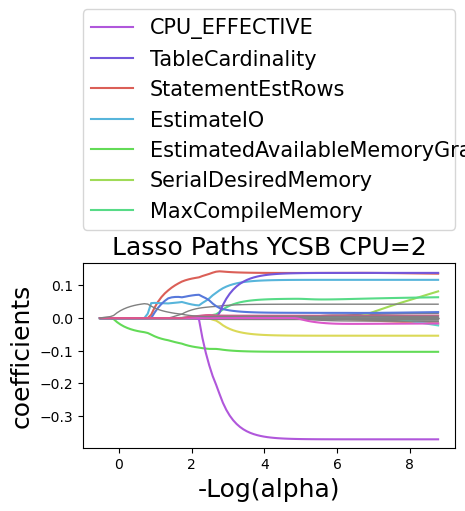

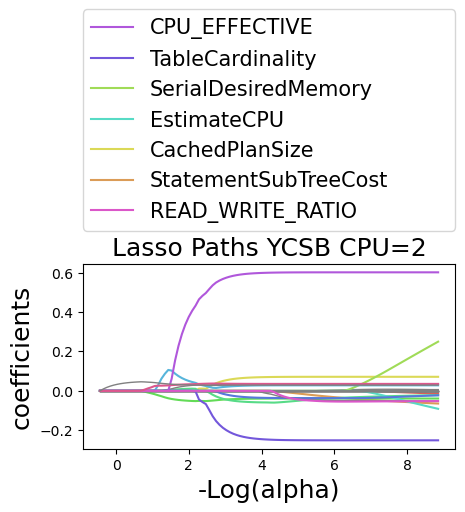

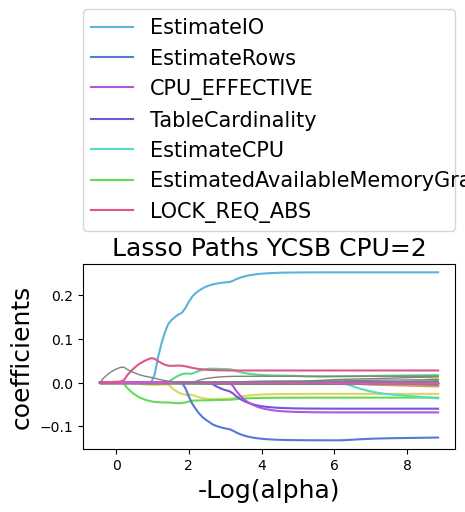

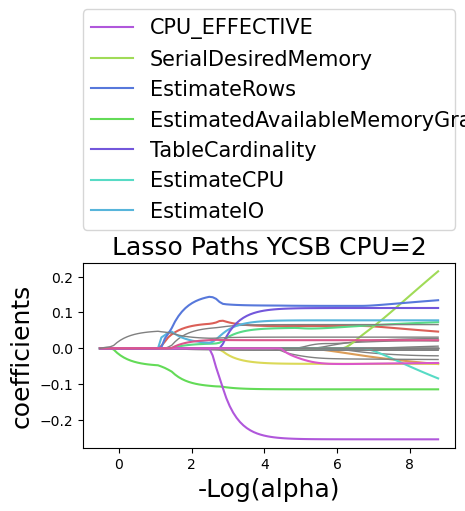

cpu_num=cpu4
cpu_num=cpu8


In [8]:
NUM_FEATURE = 7
for sku in data_by_sku.keys():
    curr_data = data_by_sku[sku]
    print(f'cpu_num={sku}')
    if 'cpu2' not in sku:
        continue
    if 'ter' in sku:
        continue
    scaler = scale_data.ScaleData()
    plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
    # print(perf_col_ranges)
    # print(perf_mtxs_splitted[0][:,4])
    simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
    simi_calc.calc_bined_mtx()
    simi_calc.calc_dist_simi_matrix()
    
    # for some experiment, its distanct to others are: 
    expr_idx = 0
    # print(simi_calc.plan_dist_mtx[0])
    
    # feature wise distance
    simi_calc.calc_featurewise_dist_by_col()
    
    # expr_num = curr_data.get_num_exprs()
    expr_num = 4
    out_exprs = list(range(27, 36))
    # out_exprs = list(range(36)) 
    sku_dict = {}

    display_features = []
    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        # calculate label
        curr_name = curr_data.wl_names[expr_idx]
        y = [curr_name == name for name in curr_data.wl_names]
        # X = simi_calc.plan_dist_by_col_cube[i]
        X = simi_calc.simi_col_mtx[expr_idx]
    
        eps = 5e-10  # the smaller it is the longer is the path
        alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)

        neg_log_alphas_lasso = -np.log10(alphas_lasso)
        weights = np.array([-1*abs(coef_l[-1]) for coef_l in coefs_lasso])

        orders = sparse_argsort(weights)
        feature_importance = [curr_data.feature_cols[j] for j in orders]
        print(curr_name, feature_importance)
        sku_dict[curr_name+str(i)] = {
            'weights': weights,
            'orders': orders,
            'fi': feature_importance,
            'alphas': neg_log_alphas_lasso,
            'lassos': coefs_lasso
        }
        display_features += list(orders[:NUM_FEATURE])
        
    display_features = np.unique(display_features)
    colors = sns.color_palette("hls", len(display_features))

    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        curr_name = curr_data.wl_names[expr_idx]
                    
        if curr_name == 'tpcc':
            title_name = 'TPC-C'
        elif curr_name == 'tpch':
            title_name = 'TPC-H'
        elif curr_name == 'twitter':
            title_name = 'Twitter';
        elif curr_name == 'ycsb':
            title_name = 'YCSB';
        curr_name = curr_name+str(i)

        fig, ax = plt.subplots(figsize=(4.8, 2.4))
        # fig, ax = plt.subplots(figsize=(6, 2.4))
        for idx, coef_l in zip(list(range(len(curr_data.feature_cols))), sku_dict[curr_name]['lassos']):
            if idx in display_features:
                # get index 
                c_idx = np.where(display_features==idx)[0][0]
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c=colors[c_idx], label=curr_data.feature_cols[idx])
            else:
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c='gray', linewidth=1, label=curr_data.feature_cols[idx])

        ax.set_title('Lasso Paths {} CPU={}'.format(title_name, int(sku[3:])))#, fontsize=14)

        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]
        labels = [labels[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]

        # ax.legend(handles,labels,bbox_to_anchor=(-0.15, 1.15, 1.15, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=11) # 
        ax.legend(handles,labels,bbox_to_anchor=(0, 1.18, 1, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)#, fontsize=11) # 
        ax.set_xlabel('-Log(alpha)')#, fontsize=12)
        ax.set_ylabel('coefficients')#, fontsize=12)
        ax.tick_params(axis='both', which='major')#, labelsize=10)

        plt.savefig(f'../figs/short_{curr_name}_lasso_path{NUM_FEATURE}_{sku}_fs.pdf', bbox_inches="tight")
        plt.show()

In [9]:
# CPU_EFFECTIVE, READ_WRITE_RATIO, EstimateCPU, IOPS_TOTAL, EstimateIO

In [10]:
expr_idxs =  [1, 17, 20, 27]

In [15]:
for sku in data_by_sku.keys():
    curr_data = data_by_sku[sku]
    print(f'cpu_num={sku}')
    if 'cpu2' not in sku:
        continue
    if 'ter' in sku:
        continue
        
    for expr_idx in expr_idxs:
        print(curr_data.wl_names[expr_idx])
        print(f"Throughput: {curr_data.wl_throughput[expr_idx]}")
        print(f"CPU_EFFECTIVE: {curr_data.query_perf_dfs[expr_idx]['CPU_EFFECTIVE'].describe()}")
        print(f"READ_WRITE_RATIO: {curr_data.query_perf_dfs[expr_idx]['READ_WRITE_RATIO'].describe()}")
        print(f"IOPS_TOTAL: {curr_data.query_perf_dfs[expr_idx]['IOPS_TOTAL'].describe()}")
        print(f"EstimateCPU: {curr_data.query_plan_dfs[expr_idx]['EstimateCPU'].describe()}")
        print(f"EstimateCPU: {curr_data.query_plan_dfs[expr_idx]['EstimateIO'].describe()}")
        print('')


cpu_num=cpu16
cpu_num=cpu2
tpcc
Throughput: 621.5829653462558
CPU_EFFECTIVE: count     61.000000
mean      99.908540
std        0.158457
min       99.351021
25%       99.954679
50%       99.969834
75%       99.978237
max      100.000000
Name: CPU_EFFECTIVE, dtype: float64
READ_WRITE_RATIO: count    61.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: READ_WRITE_RATIO, dtype: float64
IOPS_TOTAL: count    61.000000
mean      0.114754
std       0.321370
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: IOPS_TOTAL, dtype: float64
EstimateCPU: count    651.000000
mean       0.000046
std        0.000073
min        0.000000
25%        0.000001
50%        0.000001
75%        0.000158
max        0.000266
Name: EstimateCPU, dtype: float64
EstimateCPU: count    651.000000
mean       0.006445
std        0.004161
min        0.000000
25%        0.003125
50%        0.010000
75%        0.010000
m